In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import tqdm
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
import psycopg2
from json import load as json_load

from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

# Функции

In [2]:
# Функция получения абсолютных путей
def get_catalogs_way() -> dict:
    ways = dict()  # Словарь для хранения путей
    ways['way_to_py'] = os.getcwd()  # Получим путь к каталогу
    time_list = os.getcwd().split('\\')
    
    way_to_conf_file = str()
    pickle_ml_model = str()
    for one_part in time_list:

        if one_part == 'Google Диск':
            way_to_conf_file += 'Google Диск\\BI\\Боевая\\Сonfiguration files'
            ways['conf_file_connect'] = way_to_conf_file
            
            pickle_ml_model += 'Google Диск\\BI\\Боевая\\Pickle_ML_model'
            ways['pickle_ml_model'] = pickle_ml_model
            break
        way_to_conf_file += f'{one_part}\\'
        pickle_ml_model += f'{one_part}\\'
    return (ways)

In [3]:
# Функция чтения файлов настройки подключения
def get_conf_file(ways: dict) -> (dict, dict, dict, dict):
    # Получим файл настроек подключений
    read_file = open(f'{ways.get("conf_file_connect")}\\data_connect.json',
                     "r")
    dict_connect = json_load(read_file)  # Получили настройки из файла
    read_file.close()  # Закрыли файл
   
    return (dict_connect)

In [4]:
# Функция подключения к БД
def connect_postgre(dict_connect: dict, base_name: str) -> psycopg2.connect:
    # Получим данные настроек
    database = dict_connect.get(base_name).get("database")
    user = dict_connect.get(base_name).get("user")
    password = dict_connect.get(base_name).get("password")
    host = dict_connect.get(base_name).get("host")
    host = '192.168.1.19'
    port = dict_connect.get(base_name).get("port")

    # Получим объект курсор
    con = psycopg2.connect(database=database,
                           user=user,
                           password=password,
                           host=host,
                           port=port)
    return (con)

In [5]:
# Функция сохранения pickle данных
# way - Путь к папке сохранения
# request_name - Имя таблицы в БД (так же имя запросса)
# df - Данные из 1С

def pickle_data(way: str, name: str, data) -> None:    
    with open(f'{way}\\{name}.pickle', 'wb') as f:
        pickle.dump(data, f)

# Получим данные из БД

In [6]:
# Получим пути к рабочим каталогам
ways = get_catalogs_way()

# dict_connect Данные подключения к 1С и postgre
# dict_request Данные по запроссам к 1С
# dict_start Выполнение до
# dict_finish Выполнение после

dict_connect = get_conf_file(ways)

## Загрузим данные о заказах

In [7]:
con = connect_postgre(dict_connect, 'main_base')

In [8]:
sql_text = f'select * from public."сustomer_orders_with_transcripts_01"'

time_data = pd.read_sql_query(
    con=con,
    sql=sql_text,
    parse_dates={'order_date': '%Y-%m-%d'})

con.close()

In [9]:
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248433 entries, 0 to 248432
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   row_index                248433 non-null  int64         
 1   nomenklatura_id          248433 non-null  object        
 2   quantity                 248433 non-null  float64       
 3   type_of_price_id         239793 non-null  object        
 4   price                    248433 non-null  float64       
 5   amount_row               248433 non-null  float64       
 6   nds_rate                 248433 non-null  object        
 7   amount_nds               248433 non-null  float64       
 8   percent_manual_disc      248433 non-null  float64       
 9   amount_manual_disc       248433 non-null  float64       
 10  percent_auto_disc        248433 non-null  float64       
 11  amount_auto_disc         248433 non-null  float64       
 12  cancell_reason_i

In [10]:
time_data.head()

,row_index,nomenklatura_id,quantity,type_of_price_id,price,amount_row,nds_rate,amount_nds,percent_manual_disc,amount_manual_disc,...,order_date,conducted,deleted,partner_id,amount_order,manager_id,status,order_link,predicted_success,predicted_not_a_success
0,460271,00000000008,73.0,От50ТысРуб,1081.0,74967.35,18%,11435.70,0.0,0.0,...,2018-02-16,Да,Нет,000000237,1363272.8,000000014,Закрыт,Заказ клиента ЭЛ00-001632 от 16.02.2018 10:38:27,NaN,NaN
1,460272,00000007383,263.0,От50ТысРуб,876.0,218868.60,18%,33386.74,0.0,0.0,...,2018-02-16,Да,Нет,000000237,1363272.8,000000014,Закрыт,Заказ клиента ЭЛ00-001632 от 16.02.2018 10:38:27,NaN,NaN
2,460273,00-00001607,1.0,От50ТысРуб,200.0,200.00,20%,33.33,0.0,0.0,...,2020-05-14,Да,Нет,000002251,37011.0,000000014,Закрыт,Заказ клиента ЭЛ00-006848 от 14.05.2020 14:53:49,NaN,NaN
3,460274,00000005973,30.0,От50ТысРуб,486.0,14580.00,20%,2430.00,0.0,0.0,...,2020-05-14,Да,Нет,000002251,37011.0,000000014,Закрыт,Заказ клиента ЭЛ00-006848 от 14.05.2020 14:53:49,NaN,NaN
4,460275,00-00001607,1.0,От50ТысРуб,150.0,150.00,20%,25.00,0.0,0.0,...,2019-09-19,Да,Нет,000000405,154250.0,000000181,Закрыт,Заказ клиента ЭЛ00-012942 от 19.09.2019 9:32:21,NaN,NaN


In [11]:
data = time_data.copy()

## Загрузим бизнес регион

In [12]:
con = connect_postgre(dict_connect, 'main_base')

In [13]:
time_data_bus_reg = pd.read_sql_query('select * from public.partners_01', con)
con.close()

In [14]:
bus_reg = time_data_bus_reg.copy()

## Загрузим данные о растоянии Бизнес регионов

In [15]:
#rasst_df = pd.read_excel('C:\\Users\\Jon\\Google Диск\\МО\\Расстояния.xlsx')
rasst_df = pd.read_excel('C:\\Users\\e.korobkov\\Google Диск\\МО\\Расстояния.xlsx')

In [16]:
rasst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   busines_region_id                95 non-null     object 
 1   Из Москвы                        95 non-null     int64  
 2   Другая страна                    95 non-null     object 
 3   Из Новосибирска                  95 non-null     int64  
 4   Обраб-ие произ-ва, тыс руб.      58 non-null     float64
 5   Добыча пол иск тыс руб           57 non-null     float64
 6   Строительство тыс руб            58 non-null     float64
 7   Оптовая и розн торговля тыс руб  58 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 6.1+ KB


In [17]:
rasst_df

,busines_region_id,Из Москвы,Другая страна,Из Новосибирска,"Обраб-ие произ-ва, тыс руб.",Добыча пол иск тыс руб,Строительство тыс руб,Оптовая и розн торговля тыс руб
0,Азербайджан,2200,Да,4500,NaN,NaN,NaN,NaN
1,Акмолинская область,2735,Да,1025,NaN,NaN,NaN,NaN
2,Актюбинская область,1700,Нет,2200,NaN,NaN,NaN,NaN
3,Алматинская область,3916,Да,1848,NaN,NaN,NaN,NaN
4,Алтайский край,3612,Нет,230,3.436353e+08,1.526368e+07,4.858312e+07,6.037957e+08
...,...,...,...,...,...,...,...,...
90,Чувашская Республика - Чувашия,660,Нет,2700,NaN,NaN,NaN,NaN
91,Чукотская автономная область,15000,Нет,7500,1.655750e+06,1.086283e+08,4.661630e+06,2.181176e+07
92,Южно-Казахстанская область,3100,Да,2300,NaN,NaN,NaN,NaN
93,Ямало-Ненецкий автономный округ,3647,Нет,2540,5.495047e+08,2.558941e+09,1.729800e+08,1.688986e+08


# ETL for RandomForest

## Признак набора

In [18]:
for number, elem in tqdm.tqdm(data.iterrows()):
    if data.loc[number, 'nom_dialing_code_id'] is not None:
        data.at[number, 'nom_dialing_code_id'] = 'set'

248433it [00:13, 18201.49it/s]


## Удалим не нужные столбцы

In [19]:
del data['conducted']
del data['deleted']
del data['amount_order']
#del data['order_link']
del data['price']

del data['amount_row']
del data['nds_rate']
del data['amount_nds']
del data['amount_manual_disc']
del data['amount_auto_disc']

del data['cancell_reason_id']
del data['code_row']
del data['row_index']
del data['order_number']
#del data['nom_dialing_code_id']


del data['predicted_success']
del data['predicted_not_a_success']
del data['manager_id']

## Фильтр по Закрытым заказам

In [20]:
data = data.loc[data['status'] == 'Закрыт']
del data['status']

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242006 entries, 0 to 248432
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   nomenklatura_id      242006 non-null  object        
 1   quantity             242006 non-null  float64       
 2   type_of_price_id     233992 non-null  object        
 3   percent_manual_disc  242006 non-null  float64       
 4   percent_auto_disc    242006 non-null  float64       
 5   cancell              242006 non-null  object        
 6   nom_dialing_code_id  747 non-null     object        
 7   order_date           242006 non-null  datetime64[ns]
 8   partner_id           242006 non-null  object        
 9   order_link           242006 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 20.3+ MB


## Свернем Номенклатуру

In [22]:
data = data.groupby(['nomenklatura_id','type_of_price_id','cancell', 'partner_id','order_date','order_link']).agg({"quantity":"sum", "percent_manual_disc":"mean", "percent_auto_disc":"mean"})
data.reset_index(inplace=True)

In [23]:
data

,nomenklatura_id,type_of_price_id,cancell,partner_id,order_date,order_link,quantity,percent_manual_disc,percent_auto_disc
0,00-00000002,От50ТысРуб,Да,00-00000132,2020-02-27,Заказ клиента ЭЛ00-002838 от 27.02.2020 9:34:11,722.0,0.0,0.0
1,00-00000002,От50ТысРуб,Да,00-00000192,2018-02-06,Заказ клиента ЭЛ00-001155 от 06.02.2018 11:03:45,3.0,0.0,0.0
2,00-00000002,От50ТысРуб,Да,00-00000194,2020-06-10,Заказ клиента ЭЛ00-008615 от 10.06.2020 13:49:47,3.0,3.0,0.0
3,00-00000002,От50ТысРуб,Да,00-00000209,2020-10-30,Заказ клиента ЭЛ00-015360 от 30.10.2020 0:00:00,10.0,0.0,0.0
4,00-00000002,От50ТысРуб,Да,00-00000823,2021-03-11,Заказ клиента ЭЛ00-004192 от 11.03.2021 16:31:37,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
221985,00000008281,От50ТысРуб,Да,000004910,2019-10-15,Заказ клиента ЭЛ00-014345 от 15.10.2019 13:41:29,1.0,0.0,0.0
221986,00000008281,От5ТысРуб,Да,000005044,2017-10-31,Заказ клиента ЭЛ000012558 от 31.10.2017 11:49:11,4.0,0.0,0.0
221987,00000008385,От50ТысРуб,Да,00-00002360,2019-07-30,Заказ клиента ЭЛ00-010160 от 30.07.2019 10:21:50,3.0,0.0,0.0
221988,00000008398,От50ТысРуб,Нет,000000435,2020-08-18,Заказ клиента ЭЛ00-012456 от 18.08.2020 11:37:44,20.0,0.0,0.0


## Вынесем месяц_год для отображения сезонности

In [24]:
data['date'] = None
data['successful_order_date'] = None

In [25]:
for number, elem in tqdm.tqdm(data.iterrows()):
    st = f'{data["order_date"][number].year}-{data["order_date"][number].month}'
    data.at[number, 'date'] = st
    data.at[number, 'successful_order_date'] = st

221990it [00:21, 10120.12it/s]


In [26]:
del data['order_date']

## Количество успешных/неуспешных заказов по месяцам

### Сделаем partner_df для записи кол-ва успешных заказов

In [27]:
partner_df = pd.pivot_table(data, 
                            index='order_link', 
                            values=['partner_id','successful_order_date'],
                            aggfunc=np.unique)
partner_df.reset_index(inplace=True)

In [28]:
data['cancell'].value_counts()

Нет    116520
Да     105470
Name: cancell, dtype: int64

In [29]:
t_data = pd.get_dummies(data['successful_order_date'], prefix='succ_ord_date')
t_data.replace(1,0, inplace=True)
data = pd.concat([data, t_data], axis=1)

In [30]:
t_data = pd.get_dummies(data['successful_order_date'], prefix='not_succ_ord_date')
t_data.replace(1,0, inplace=True)
data = pd.concat([data, t_data], axis=1)

In [31]:
partner_df['successful_order'] = None
partner_df['not_successful_order'] = None

In [32]:
for order in tqdm.tqdm(data['order_link'].unique()):
    if 'Нет' in list(data.loc[data['order_link'] == order]['cancell']):
        t_index = partner_df.loc[partner_df['order_link'] == order].index
        partner_df.at[t_index, 'successful_order'] = 1

    if 'Да' in list(data.loc[data['order_link'] == order]['cancell']):
        t_index = partner_df.loc[partner_df['order_link'] == order].index
        partner_df.at[t_index, 'not_successful_order'] = 1
      

100%|████████████████████████████████████████████████████████████████████████████| 60718/60718 [46:54<00:00, 21.57it/s]


In [33]:
data = data.reset_index()
del data['index']

### Запишем данные в основной df

In [34]:
for partner_id in tqdm.tqdm(data['partner_id'].unique()):
    t_data = partner_df.loc[partner_df['partner_id'] == partner_id]
    for year_mounth in t_data['successful_order_date'].unique():
        # не отмененные заказы: Cancell = Нет
        sum_ord = t_data.loc[t_data['successful_order_date'] == year_mounth]['successful_order'].sum()
        if sum_ord > 0:
            index_to_change = t_data.loc[t_data['successful_order_date'] == year_mounth].index
            mounth_key = f'succ_ord_date_{str(year_mounth)}'
            data.at[index_to_change, mounth_key] = sum_ord

        # отмененный заказ: Cancell = Да
        sum_ord = t_data.loc[t_data['successful_order_date'] == year_mounth]['not_successful_order'].sum()
        if sum_ord > 0:
            index_to_change = t_data.loc[t_data['successful_order_date'] == year_mounth].index
            mounth_key = f'not_succ_ord_date_{str(year_mounth)}'
            data.at[index_to_change, mounth_key] = sum_ord
           

100%|█████████████████████████████████████████████████████████████████████████████| 5105/5105 [00:43<00:00, 116.63it/s]


In [35]:
data

,nomenklatura_id,type_of_price_id,cancell,partner_id,order_link,quantity,percent_manual_disc,percent_auto_disc,date,successful_order_date,...,not_succ_ord_date_2020-4,not_succ_ord_date_2020-5,not_succ_ord_date_2020-6,not_succ_ord_date_2020-7,not_succ_ord_date_2020-8,not_succ_ord_date_2020-9,not_succ_ord_date_2021-1,not_succ_ord_date_2021-2,not_succ_ord_date_2021-3,not_succ_ord_date_2021-4
0,00-00000002,От50ТысРуб,Да,00-00000132,Заказ клиента ЭЛ00-002838 от 27.02.2020 9:34:11,722.0,0.0,0.0,2020-2,2020-2,...,0,0,0,0,0,0,0,0,0,0
1,00-00000002,От50ТысРуб,Да,00-00000192,Заказ клиента ЭЛ00-001155 от 06.02.2018 11:03:45,3.0,0.0,0.0,2018-2,2018-2,...,0,0,0,0,0,0,0,0,0,0
2,00-00000002,От50ТысРуб,Да,00-00000194,Заказ клиента ЭЛ00-008615 от 10.06.2020 13:49:47,3.0,3.0,0.0,2020-6,2020-6,...,0,0,0,0,0,0,0,0,0,0
3,00-00000002,От50ТысРуб,Да,00-00000209,Заказ клиента ЭЛ00-015360 от 30.10.2020 0:00:00,10.0,0.0,0.0,2020-10,2020-10,...,0,0,0,0,0,0,0,0,0,0
4,00-00000002,От50ТысРуб,Да,00-00000823,Заказ клиента ЭЛ00-004192 от 11.03.2021 16:31:37,3.0,0.0,0.0,2021-3,2021-3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221985,00000008281,От50ТысРуб,Да,000004910,Заказ клиента ЭЛ00-014345 от 15.10.2019 13:41:29,1.0,0.0,0.0,2019-10,2019-10,...,0,0,0,0,0,0,0,0,0,0
221986,00000008281,От5ТысРуб,Да,000005044,Заказ клиента ЭЛ000012558 от 31.10.2017 11:49:11,4.0,0.0,0.0,2017-10,2017-10,...,0,0,0,0,0,0,0,0,0,0
221987,00000008385,От50ТысРуб,Да,00-00002360,Заказ клиента ЭЛ00-010160 от 30.07.2019 10:21:50,3.0,0.0,0.0,2019-7,2019-7,...,0,0,0,0,0,0,0,0,0,0
221988,00000008398,От50ТысРуб,Нет,000000435,Заказ клиента ЭЛ00-012456 от 18.08.2020 11:37:44,20.0,0.0,0.0,2020-8,2020-8,...,0,0,0,0,0,0,0,0,0,0


## Вынесем бизнес регион

In [36]:
data['rast'] = np.nan

In [37]:
for part_id in tqdm.tqdm(data['partner_id'].unique()):
    index_part = data.loc[data['partner_id'] == part_id].index
    bus_reg_name = bus_reg.loc[bus_reg['partner_id'] == part_id]['busines_region_id'].values[0]
    rez = rasst_df.loc[rasst_df['busines_region_id'] == bus_reg_name]['Из Москвы'] - rasst_df.loc[rasst_df['busines_region_id'] == bus_reg_name]['Из Новосибирска']
    othez_country = rasst_df.loc[rasst_df['busines_region_id'] == bus_reg_name]['Другая страна']
    if len(othez_country) > 0:
        data.at[index_part, 'other country'] = othez_country.values[0]
    if len(rez) > 0:
        data.at[index_part, 'rast'] = rez.values[0]

100%|██████████████████████████████████████████████████████████████████████████████| 5105/5105 [01:36<00:00, 52.89it/s]


In [38]:
data.columns

Index(['nomenklatura_id', 'type_of_price_id', 'cancell', 'partner_id',
       'order_link', 'quantity', 'percent_manual_disc', 'percent_auto_disc',
       'date', 'successful_order_date',
       ...
       'not_succ_ord_date_2020-6', 'not_succ_ord_date_2020-7',
       'not_succ_ord_date_2020-8', 'not_succ_ord_date_2020-9',
       'not_succ_ord_date_2021-1', 'not_succ_ord_date_2021-2',
       'not_succ_ord_date_2021-3', 'not_succ_ord_date_2021-4', 'rast',
       'other country'],
      dtype='object', length=121)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221990 entries, 0 to 221989
Columns: 121 entries, nomenklatura_id to other country
dtypes: float64(4), object(9), uint8(108)
memory usage: 44.9+ MB


In [40]:
data['rast'].isnull().sum()

3

In [41]:
data['rast'] = data['rast'].replace(np.nan, 99999)

In [42]:
data

,nomenklatura_id,type_of_price_id,cancell,partner_id,order_link,quantity,percent_manual_disc,percent_auto_disc,date,successful_order_date,...,not_succ_ord_date_2020-6,not_succ_ord_date_2020-7,not_succ_ord_date_2020-8,not_succ_ord_date_2020-9,not_succ_ord_date_2021-1,not_succ_ord_date_2021-2,not_succ_ord_date_2021-3,not_succ_ord_date_2021-4,rast,other country
0,00-00000002,От50ТысРуб,Да,00-00000132,Заказ клиента ЭЛ00-002838 от 27.02.2020 9:34:11,722.0,0.0,0.0,2020-2,2020-2,...,0,0,0,0,0,0,0,0,3374.0,Нет
1,00-00000002,От50ТысРуб,Да,00-00000192,Заказ клиента ЭЛ00-001155 от 06.02.2018 11:03:45,3.0,0.0,0.0,2018-2,2018-2,...,0,0,0,0,0,0,0,0,-574.0,Нет
2,00-00000002,От50ТысРуб,Да,00-00000194,Заказ клиента ЭЛ00-008615 от 10.06.2020 13:49:47,3.0,3.0,0.0,2020-6,2020-6,...,0,0,0,0,0,0,0,0,3374.0,Нет
3,00-00000002,От50ТысРуб,Да,00-00000209,Заказ клиента ЭЛ00-015360 от 30.10.2020 0:00:00,10.0,0.0,0.0,2020-10,2020-10,...,0,0,0,0,0,0,0,0,3354.0,Нет
4,00-00000002,От50ТысРуб,Да,00-00000823,Заказ клиента ЭЛ00-004192 от 11.03.2021 16:31:37,3.0,0.0,0.0,2021-3,2021-3,...,0,0,0,0,0,0,0,0,3354.0,Нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221985,00000008281,От50ТысРуб,Да,000004910,Заказ клиента ЭЛ00-014345 от 15.10.2019 13:41:29,1.0,0.0,0.0,2019-10,2019-10,...,0,0,0,0,0,0,0,0,3354.0,Нет
221986,00000008281,От5ТысРуб,Да,000005044,Заказ клиента ЭЛ000012558 от 31.10.2017 11:49:11,4.0,0.0,0.0,2017-10,2017-10,...,0,0,0,0,0,0,0,0,3368.0,Нет
221987,00000008385,От50ТысРуб,Да,00-00002360,Заказ клиента ЭЛ00-010160 от 30.07.2019 10:21:50,3.0,0.0,0.0,2019-7,2019-7,...,0,0,0,0,0,0,0,0,3382.0,Нет
221988,00000008398,От50ТысРуб,Нет,000000435,Заказ клиента ЭЛ00-012456 от 18.08.2020 11:37:44,20.0,0.0,0.0,2020-8,2020-8,...,0,0,0,0,0,0,0,0,3374.0,Нет


## Проверка на пустоты

In [43]:
for col in data.columns:
    print(data[col].isnull().sum(), col)

0 nomenklatura_id
0 type_of_price_id
0 cancell
0 partner_id
0 order_link
0 quantity
0 percent_manual_disc
0 percent_auto_disc
0 date
0 successful_order_date
0 time_1
0 succ_ord_date_2015-5
0 succ_ord_date_2015-9
0 succ_ord_date_2016-10
0 succ_ord_date_2016-11
0 succ_ord_date_2016-4
0 succ_ord_date_2016-6
0 succ_ord_date_2016-9
0 succ_ord_date_2017-10
0 succ_ord_date_2017-11
0 succ_ord_date_2017-12
0 succ_ord_date_2017-3
0 succ_ord_date_2017-7
0 succ_ord_date_2017-8
0 succ_ord_date_2017-9
0 succ_ord_date_2018-1
0 succ_ord_date_2018-10
0 succ_ord_date_2018-11
0 succ_ord_date_2018-12
0 succ_ord_date_2018-2
0 succ_ord_date_2018-3
0 succ_ord_date_2018-4
0 succ_ord_date_2018-5
0 succ_ord_date_2018-6
0 succ_ord_date_2018-7
0 succ_ord_date_2018-8
0 succ_ord_date_2018-9
0 succ_ord_date_2019-1
0 succ_ord_date_2019-10
0 succ_ord_date_2019-11
0 succ_ord_date_2019-12
0 succ_ord_date_2019-2
0 succ_ord_date_2019-3
0 succ_ord_date_2019-4
0 succ_ord_date_2019-5
0 succ_ord_date_2019-6
0 succ_ord_date_20

In [44]:
data['type_of_price_id'] = data['type_of_price_id'].replace(np.nan, 'Произвольная')
data['type_of_price_id'] = data['type_of_price_id'].replace('От50ТысРубКЗДля19Года', 'От50ТысРубКЗ')
data['type_of_price_id'] = data['type_of_price_id'].replace('От5ТысРубКЗДля19Года', 'От5ТысРубКЗ')

In [45]:
del data['order_link']

## Добавим данные о кластерах Партнеров

In [52]:
klaster_df = pd.read_excel('C:\\Users\\Jon\\Google Диск\\МО\\Кластеризация Партнеров\\Партнеры + кластеры.xlsx')

In [53]:
klaster_df

,index,new_KMeans_1,new_DBSCAN_1,new_linkage_1,new_OPTICS_1,new_AgglomClust_1,new_Spectral_1,new_KMeans_2,new_DBSCAN_2,new_linkage_2,...,new_linkage_6,new_OPTICS_6,new_AgglomClust_6,new_Spectral_6,new_KMeans_7,new_DBSCAN_7,new_linkage_7,new_OPTICS_7,new_AgglomClust_7,new_Spectral_7
0,000004793,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,97.0,...,109.0,-1.0,220.0,1.0,8.0,0.0,54.0,0.0,143.0,1.0
1,000006094,0.0,2.0,44.0,-1.0,101.0,16.0,18.0,1.0,77.0,...,22.0,44.0,60.0,2.0,26.0,1.0,24.0,-1.0,46.0,3.0
2,000005500,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1.0,9.0,...,38.0,-1.0,92.0,2.0,26.0,1.0,26.0,-1.0,60.0,16.0
3,000006634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,-1.0,17.0,6.0,15.0,2.0,2.0,-1.0,2.0,19.0
4,00-00004272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,3.0,60.0,-1.0,158.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5371,00-00004245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.0,-1.0,111.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
5372,00-00004246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.0,-1.0,68.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
5373,00-00004247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,65.0,26.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5374,00-00004249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,111.0,94.0,223.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_copy = data.copy()

In [176]:
data = data_copy.copy()

In [158]:
data = data_copy.copy()
data['new_Spectral_1'] = None
data['new_Spectral_2'] = None
data['new_Spectral_3'] = None
data['new_Spectral_4'] = None
data['new_Spectral_5'] = None
data['new_Spectral_6'] = None
data['new_Spectral_7'] = None

In [159]:
#data['node'] = None
for part_id in tqdm.tqdm(data['partner_id'].unique()):
    partner_index = data.loc[data['partner_id'] == part_id].index
    for col in ['new_Spectral_1', 'new_Spectral_2', 'new_Spectral_3', 'new_Spectral_4', 'new_Spectral_5','new_Spectral_6','new_Spectral_7']:
        if klaster_df.loc[klaster_df['index'] == part_id][col].values.shape[0] == 1:
            node = klaster_df.loc[klaster_df['index'] == part_id][col].values[0]
            data.at[partner_index, col] = node

100%|██████████████████████████████████████████████████████████████████████████████| 5096/5096 [03:20<00:00, 25.41it/s]


In [160]:
data.isnull().sum()

nomenklatura_id         0
type_of_price_id        0
cancell                 0
partner_id              0
quantity                0
                    ...  
new_Spectral_3      38118
new_Spectral_4      27299
new_Spectral_5      32279
new_Spectral_6      30201
new_Spectral_7      44991
Length: 72, dtype: int64

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220550 entries, 0 to 220549
Data columns (total 72 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   nomenklatura_id        220550 non-null  object 
 1   type_of_price_id       220550 non-null  object 
 2   cancell                220550 non-null  object 
 3   partner_id             220550 non-null  object 
 4   quantity               220550 non-null  float64
 5   percent_manual_disc    220550 non-null  object 
 6   percent_auto_disc      220550 non-null  object 
 7   date                   220550 non-null  object 
 8   successful_order_date  220550 non-null  object 
 9   succ_ord_date_2015-5   220550 non-null  uint8  
 10  succ_ord_date_2015-9   220550 non-null  uint8  
 11  succ_ord_date_2016-10  220550 non-null  uint8  
 12  succ_ord_date_2016-11  220550 non-null  uint8  
 13  succ_ord_date_2016-4   220550 non-null  uint8  
 14  succ_ord_date_2016-6   220550 non-nu

In [46]:
## Сделаем копию df

In [47]:
data_copy = data.copy()

In [ ]:
data = data_copy.copy()

## Удалим времеенные переменные

In [56]:
del data['successful_order_date']
del data['date']
del data['time_1']

## Переделаем в dummi переменные

In [57]:
print("Исходные переменные:\n", list(data.columns), "\n")
data_dummies_full = pd.get_dummies(data)
print("Переменные после get_dummies:\n", list(data_dummies_full.columns))

Исходные переменные:
 ['nomenklatura_id', 'type_of_price_id', 'cancell', 'partner_id', 'quantity', 'percent_manual_disc', 'percent_auto_disc', 'succ_ord_date_2015-5', 'succ_ord_date_2015-9', 'succ_ord_date_2016-10', 'succ_ord_date_2016-11', 'succ_ord_date_2016-4', 'succ_ord_date_2016-6', 'succ_ord_date_2016-9', 'succ_ord_date_2017-10', 'succ_ord_date_2017-11', 'succ_ord_date_2017-12', 'succ_ord_date_2017-3', 'succ_ord_date_2017-7', 'succ_ord_date_2017-8', 'succ_ord_date_2017-9', 'succ_ord_date_2018-1', 'succ_ord_date_2018-10', 'succ_ord_date_2018-11', 'succ_ord_date_2018-12', 'succ_ord_date_2018-2', 'succ_ord_date_2018-3', 'succ_ord_date_2018-4', 'succ_ord_date_2018-5', 'succ_ord_date_2018-6', 'succ_ord_date_2018-7', 'succ_ord_date_2018-8', 'succ_ord_date_2018-9', 'succ_ord_date_2019-1', 'succ_ord_date_2019-10', 'succ_ord_date_2019-11', 'succ_ord_date_2019-12', 'succ_ord_date_2019-2', 'succ_ord_date_2019-3', 'succ_ord_date_2019-4', 'succ_ord_date_2019-5', 'succ_ord_date_2019-6', 'succ_

In [44]:
display(data_dummies_full)

,quantity,percent_manual_disc,percent_auto_disc,nomenklatura_id_00-00000002,nomenklatura_id_00-00000031,nomenklatura_id_00-00000032,nomenklatura_id_00-00000033,nomenklatura_id_00-00000034,nomenklatura_id_00-00000035,nomenklatura_id_00-00000049,...,time_1_2020-4,time_1_2020-5,time_1_2020-6,time_1_2020-7,time_1_2020-8,time_1_2020-9,time_1_2021-1,time_1_2021-2,time_1_2021-3,time_1_2021-4
0,722.0,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,3.0,0.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,10.0,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221985,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221986,4.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221987,3.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221988,20.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Разделение данных

In [64]:
y = data_dummies_full.loc[:, 'cancell_Нет']

In [65]:
data_dummies_full.drop('cancell_Нет', axis=1, inplace=True)
data_dummies_full.drop('cancell_Да', axis=1, inplace=True)

In [66]:
X = data_dummies_full

In [ ]:
# row_index удалим именно здесь, т.к. если удалить в основном наборе
# то данных столбец удалиться из ETL процесса новых данных
del X['row_index']

In [67]:
X

,quantity,percent_manual_disc,percent_auto_disc,succ_ord_date_2015-5,succ_ord_date_2015-9,succ_ord_date_2016-10,succ_ord_date_2016-11,succ_ord_date_2016-4,succ_ord_date_2016-6,succ_ord_date_2016-9,...,partner_id_000006897,partner_id_000006902,partner_id_000006944,partner_id_000006956,partner_id_000006963,partner_id_000006998,partner_id_000007001,partner_id_000007018,other country_Да,other country_Нет
0,722.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3.0,3.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221985,1.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
221986,4.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
221987,3.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
221988,20.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Сохранения pickle данных

In [68]:
pickle_data(ways.get('pickle_ml_model'), 'dummies_list', data_dummies_full.columns)

# Строим Forest

In [69]:
# Импортируем из модуля sklearn.model_selection функцию train_test_split
from sklearn.model_selection import train_test_split
# Выполняем разбиение на обучение и контроль
X_train, X_control, y_train, y_control = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
print(y_train.value_counts())
print(y_control.value_counts())

1    81441
0    73952
Name: cancell_Нет, dtype: int64
1    35079
0    31518
Name: cancell_Нет, dtype: int64


In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
forest=RandomForestClassifier(random_state=152)

In [73]:
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=152)

In [66]:
pickle_data(ways.get('pickle_ml_model'), 'model_for_predict_order', forest)

In [74]:
print("Правильность на обучающей выборке: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на контрольной выборке: {:.3f}".format(forest.score(X_control, y_control)))

Правильность на обучающей выборке: 0.967
Правильность на контрольной выборке: 0.775


In [167]:
forest2 = RandomForestClassifier(n_estimators=300, oob_score=True, random_state=152, verbose=1)
forest2.fit(X_train, y_train)
print("Правильность на обучающей выборке: {:.3f}".format(forest2.score(X_train, y_train)))
print("OOB оценка правильности: {:.2f}".format(forest2.oob_score_))
print("Правильность на контрольной выборке: {:.3f}".format(forest2.score(X_control, y_control)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 49.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   56.2s finished


Правильность на обучающей выборке: 0.991
OOB оценка правильности: 0.85


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Правильность на контрольной выборке: 0.849


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   25.5s finished


## Важности предикторов 

In [73]:
# Создаем объект с названиями предикторов
feat_labels = X.columns
# Создаем объект со значениями важностей, вычисленными моделью forest2
importances = forest2.feature_importances_
# Задаем сортировку значений важности и сопоставляем названия предикторов важностям
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 35,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) quantity                            0.083596
 2) rast                                0.036629
 3) percent_auto_disc                   0.018882
 4) percent_manual_disc                 0.014918
 5) type_of_price_id_Произвольная       0.005172
 6) partner_id_000005380                0.005075
 7) partner_id_000002473                0.004987
 8) partner_id_000003234                0.004774
 9) date_2020-3                         0.004333
10) date_2019-10                        0.004306
11) date_2020-5                         0.004225
12) type_of_price_id_От50ТысРуб         0.004103
13) partner_id_000000198                0.004028
14) date_2019-11                        0.003945
15) date_2019-9                         0.003808
16) date_2020-4                         0.003686
17) date_2018-4                         0.003675
18) nomenklatura_id_00000000009         0.003654
19) date_2020-1                         0.003653
20) date_2020-2                         0.003580
21) date_2019-12    

In [45]:
# Вычисляем с помощью метода predict прогнозы для контрольной выборки 
# и записываем в объект pred_forest2
pred_forest2 = forest2.predict(X_control)
# Из модуля sklearn.metrics импортируем функцию confusion_matrix
from sklearn.metrics import confusion_matrix
# Вычисляем матрицу ошибок, передав функции confusion_matrix в качестве аргументов 
# фактические значения зависимой переменной, записанные в y_control, и спрогнозированные 
# значения зависимой переменной, записанные в pred_forest2
confusion = confusion_matrix(y_control, pred_forest2)
# Печатаем матрицу ошибок
print("Матрица ошибок:\n{}".format(confusion))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   33.3s finished


Матрица ошибок:
[[26169  6364]
 [ 5055 32908]]


## Отчет о результатах классификации: точность, полнота и F-мера

In [74]:
# Из модуля sklearn.metrics импортируем функцию classification_report
from sklearn.metrics import classification_report
# Вычисляем значения точности, полноты и f-меры для классов и печатаем их
print(classification_report(y_control, pred_forest2,
                            target_names=["cancell_Нет", "cancell_Да"]))

NameError: name 'pred_forest2' is not defined

## Построение ROC-кривой и выбор оптимального порога

In [ ]:
# Вычисляем с помощью метода predict_proba прогнозы
# для контрольной выборки и печатаем их
print("Форма вероятностей: {}".format(forest2.predict_proba(X_control).shape))

In [ ]:
# Выведем первые несколько элементов predict_proba
print("Спрогнозированные вероятности:\n{}".format(forest2.predict_proba(X_control[:5])))

In [ ]:
# Из модуля sklearn.metrics импортируем функцию roc_curve
from sklearn.metrics import roc_curve
# Вычисляем значения FPR и TPR для всех возможных порогов отсечения, передав функции 
# roc_curve в качестве аргументов фактические значения зависимой переменной, 
# записанные в y_control, и вероятности положительного класса, вычисленные 
# с помощью метода predict_proba
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_control, forest2.predict_proba(X_control)[:, 1])

# Создаем заголовок ROC-кривой
plt.plot(fpr_rf, tpr_rf, label="ROC-кривая RF")
# Задаем название для оси x
plt.xlabel("FPR")
# Задаем название для оси y
plt.ylabel("TPR (полнота)")
# Задаем порог отсечения по умолчанию 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
# Строим ROC-кривую и наносим порог отсечения 0.5
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="порог 0.5 RF", fillstyle="none", c='k', mew=2)
# Задаем расположение легенды
plt.legend(loc=4)

## Улучшение качества модели случайного леса

### Методы перекрестной проверки, реализованные в scikit-learn

In [50]:
from sklearn.model_selection import cross_val_score, KFold

In [51]:
kfold = KFold(n_splits=10)

In [55]:
print("Значения правильности перекрестной проверки:\n{}".
      format(cross_val_score(forest2, X, y, cv=kfold)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
kfold = KFold(n_splits=10)
scores_acc_rf = cross_val_score(forest2, X, y, cv=kfold)
print("Среднее значение правильности перекрестной проверки: {:.2f}".
      format(scores_acc_rf.mean()))

In [ ]:
from sklearn.model_selection import StratifiedKFold
strat_split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(forest2, X, y, scoring='roc_auc', cv=strat_split)
print("Среднее значение AUC стратифицированной перекрестной проверки: {:.2f}".
      format(scores.mean()))

## Поиск оптимальных параметров случайного леса

### Получение базовой информации для решетчатого поиска

In [52]:
from math import fabs
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [53]:
def sdvig(spisok_znacheniy, kontorl, train_auc, test_auc, delta, delta_auc):
        
    # Если ещё не было запусков (test_acc пустой), вернем первое значение в списке
    if not test_auc:
        return spisok_znacheniy[0],True, delta, spisok_znacheniy, True
    
    # При втором запуске вернем последнее дерево в списке
    if len(test_auc) == 1:
        return spisok_znacheniy[-1], True, delta, spisok_znacheniy, True
    
    # Вичисляем следующий шаг
    ## Сначала вычислим лучшее значение искомоего показателя по AUC
    train_auc_new, test_auc_new = np.asarray(train_auc), np.asarray(test_auc) # Преобразуем списки в массивы NumPy
    delta = max(test_auc_new.mean(axis=1)) # Получим актуальный максимум AUC
    features = spisok_znacheniy[np.argmax(test_auc_new.mean(axis=1))] # Получим лучшее значение кол-ва деревьев по значению AUC
    
    ## Если лучшее AUC это первый элемент в списке spisok_znacheniy
    if spisok_znacheniy.index(features) == 0:
        # Вернем команду остановки вычислений
        return spisok_znacheniy[0], False, delta, spisok_znacheniy, True
    
    ## Если лучшее значение AUC это последний элемент в списке spisok_znacheniy
    ## то добавим новое количество признаков
    if spisok_znacheniy.index(features) == (len(spisok_znacheniy)-1):
        
        #Вычислим на сколько произошло увеличение AUC
        test_auc_new = np.asarray(test_auc[:-1]) # Возьмем без последнего значения
        priviosly_delta = max(test_auc_new.mean(axis=1)) # Получим Максимум на шаг-2
        
        # Усли AUC увеличился на значение большее чем delta_auc, то добавим еще шаг
        if delta_auc < (delta - priviosly_delta):
            print('Значение AUC на шаге-2 ', priviosly_delta)
            print('Значение AUC на шаг-1 ', delta)
            print('Разница AUC: "шаг-2" - "шаг-1"', delta - priviosly_delta)
            
            spisok_znacheniy.append(spisok_znacheniy[-1] * 3) # Увеличим шаг, добавим последним элементом в список
            print('Увеличим шаг. Следующий шаг = ',spisok_znacheniy[-1])
            return spisok_znacheniy[-1], True, delta, spisok_znacheniy, True
    
    # Если произошло ухудшение модели или не достаточное улучшение
    spisok_znacheniy.append(spisok_znacheniy[-1] - spisok_znacheniy[-2]) # Добавим новый элемент, для последующего вычислеия AUC
    
    print('Значение AUC на шаге-2 ', priviosly_delta)
    print('Значение AUC на шаг-1 ', delta)
    print('Разница AUC: "шаг-2" - "шаг-1"', delta - priviosly_delta)
    print('Вставим уменьшенное значение шага= ', spisok_znacheniy[-1])
    
    return spisok_znacheniy[-1], True, delta, spisok_znacheniy, False

In [60]:
# Отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Создаем экземляр класса StratifiedKFold 
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Создаем списки для сохранения правильности на обучающей и контрольной выборках
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
# Список с начальным количесвтом деревьев
trees_grid = [5, 250]

delta_auc = 0.005 # Минимальное значение изменения модели
kontrol = True # Служит для запуска следующей итерации
kontrol2 = True # Контроль последнего запуска
delta = 0 # Для записи предыдущего значения

start = datetime.now()
while kontrol:
    start_elem = datetime.now()
    ntrees, kontrol, delta, trees_grid, kontrol2 = sdvig(trees_grid, kontrol, train_acc, test_acc, delta, delta_auc)
    
    # Если первый элемент имеет наилучшее значение AUC, то прервем цикл
    if kontrol == False:
        print('Прервали расчеты')
        print('')
        break
    print('')
    print(f'*** Начали строить модель с числом деревьев {ntrees} в {datetime.now()}')
    
    # Строим модели с разным количеством деревьев
    rf = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, verbose=0)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        temp_train_acc.append(rf.score(X_train, y_train))
        temp_test_acc.append(rf.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
    print(f'Затрачено времени на итерацию: {datetime.now() - start_elem}')    
    # Контроль последнего цикла запуска
    if kontrol2 == False:
        print('Остановка по второму контролю')
        print('')
        break
    
    # Вычислим значение AUC
    test_aсc_new = np.asarray(test_acc)
    delta = max(test_aсc_new.mean(axis=1))

print('')
print(f'Всего затратили времени: {datetime.now() - start}')
    
# Преобразуем списки в массивы NumPy
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Наилучшее значение правильности перекрестной проверки равно {:.2f}% и достигается при {} деревьях".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))
n_estimators = trees_grid[np.argmax(test_acc.mean(axis=1))]
print('Дальнейшая работа будет проводиться при ', n_estimators, ' деревьях')


*** Начали строить модель с числом деревьев 5 в 2021-03-21 17:58:21.116168
Затрачено времени на итерацию: 0:12:51.475516

*** Начали строить модель с числом деревьев 250 в 2021-03-21 18:11:12.607311
Затрачено времени на итерацию: 2:17:03.000360
Значение AUC на шаге-2  0.8086345664457497
Значение AUC на шаг-1  0.8429602113335963
Разница AUC: "шаг-2" - "шаг-1" 0.03432564488784662
Увеличим шаг. Следующий шаг =  750

*** Начали строить модель с числом деревьев 750 в 2021-03-21 20:28:15.606401
Затрачено времени на итерацию: 6:27:35.362338
Значение AUC на шаге-2  0.8429602113335963
Значение AUC на шаг-1  0.8436964235590185
Разница AUC: "шаг-2" - "шаг-1" 0.0007362122254221948
Вставим уменьшенное значение шага=  500

*** Начали строить модель с числом деревьев 500 в 2021-03-22 02:55:50.984363
Затрачено времени на итерацию: 4:24:18.879384
Остановка по второму контролю


Всего затратили времени: 13:21:48.763206
Наилучшее значение правильности перекрестной проверки равно 84.37% и достигается при

Text(0.5, 0, 'Количество деревьев')

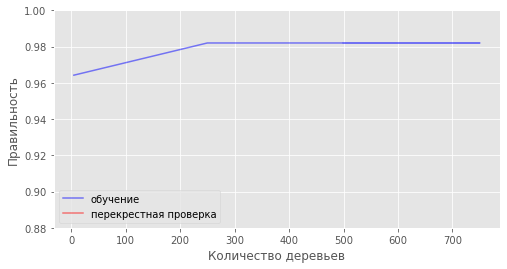

In [61]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', 
        label='обучение')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', 
        label='перекрестная проверка')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.80,1.00])
ax.set_ylabel("Правильность")
ax.set_xlabel("Количество деревьев")

### Строим модель с разным количеством признаков

In [62]:
# Отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Создаем экземляр класса StratifiedKFold 
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Создаем списки для сохранения AUC на обучающей и контрольной выборках
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
# Список с начальным количесвтом признаков
max_features_grid = [10, 500]

delta_auc = 0.005 # Минимальное значение изменения модели
kontrol = True # Служит для запуска следующей итерации
kontrol2 = True # Контроль последнего запуска
delta = 0 # Для записи предыдущего значения

start = datetime.now()
# Строим модели с разным количеством признаков
while kontrol:
    start_elem = datetime.now()
    features_grid, kontrol, delta, max_features_grid, kontrol2 = sdvig(max_features_grid, kontrol, train_auc, test_auc, delta, delta_auc)
    
    # Если первый элемент имеет наилучшее значение AUC, то прервем цикл
    if kontrol == False:
        print('Прервали расчеты')
        print('')
        break
    print('')
    print(f'*** Начали строить модель с числом предикторов {features_grid} в {datetime.now()}')
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1, max_features=features_grid, verbose=0)
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    
    print(f'Затрачено времени на итерацию: {datetime.now() - start_elem}')    
    # Контроль последнего цикла запуска
    if kontrol2 == False:
        print('Остановка по второму контролю')
        print('')
        break
        
    test_auc_new = np.asarray(test_auc)
    delta = max(test_auc_new.mean(axis=1))

print('')
print(f'Всего затратили времени: {datetime.now() - start}')

# Преобразуем списки в массивы NumPy
train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
print("Наилучшее значение AUC перекрестной проверки равно {:.3f} и достигается при {} предикторах".format(max(test_auc.mean(axis=1)), 
                                                        max_features_grid[np.argmax(test_auc.mean(axis=1))]))
features_grid = max_features_grid[np.argmax(test_auc.mean(axis=1))]
print(f'Дальнейшая работа будет проводиться при {features_grid} предикторах')


*** Начали строить модель с числом предикторов 10 в 2021-03-22 07:20:16.380755
Затрачено времени на итерацию: 5:26:48.867205

*** Начали строить модель с числом предикторов 500 в 2021-03-22 12:47:05.279212


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_features_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_features_grid, test_auc.mean(axis=1) - test_auc.std(axis=1), test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1), test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.80,1.02])
ax.set_ylabel("AUC")
ax.set_xlabel("Количество случайно отбираемых предикторов для разбиения")

### Строим модель с разным значением глубины

In [ ]:
# Отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Создаем экземляр класса StratifiedKFold 
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Создаем списки для сохранения AUC на обучающей и контрольной выборках
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
max_depth_grid = [3, 10]

delta_auc = 0.005 # Минимальное значение изменения модели
kontrol = True # Служит для запуска следующей итерации
kontrol2 = True # Контроль последнего запуска
delta = 0 # Для записи предыдущего значения

start = datetime.now()
# Строим модели с разным значением глубины
while kontrol:
    start_elem = datetime.now()
    depth_grid, kontrol, delta, max_depth_grid, kontrol2 = sdvig(max_depth_grid, kontrol, train_auc, test_auc, delta, delta_auc)

    # Если нет смысла дальше считать, то прервем цикл
    if kontrol == False:
        print('Прервали расчеты')
        print('')
        break
    print('')
    print(f'*** Начали строить модель с числом глубины {depth_grid} в {datetime.now()}')
  
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1, max_depth=depth_grid, verbose=0)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    
    print(f'Затрачено времени на итерацию: {datetime.now() - start_elem}')    
    # Контроль последнего цикла запуска
    if kontrol2 == False:
        print('Остановка по второму контролю')
        print('')
        break
        
    test_auc_new = np.asarray(test_auc)
    delta = max(test_auc_new.mean(axis=1))
    
print('')
print(f'Всего затратили времени: {datetime.now() - start}')

# Преобразуем списки в массивы NumPy
train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
print("Наилучшее значение AUC перекрестной проверки равно {:.3f} и достигается при максимальной глубине {}".format(max(test_auc.mean(axis=1)), 
                                                        max_depth_grid[np.argmax(test_auc.mean(axis=1))]))

depth_grid = max_depth_grid[np.argmax(test_auc.mean(axis=1))]
print(f'Дальнейшая работа будет проводиться при {depth_grid} глубине')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_depth_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - test_auc.std(axis=1), test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1), test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.80, 1.02])
ax.set_ylabel("AUC")
ax.set_xlabel("Максимальная глубина")

### Строим модель с разным количеcтвом наблюдений в листе

In [ ]:
# Отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Создаем экземляр класса StratifiedKFold 
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Создаем списки для сохранения AUC на обучающей и контрольной выборках
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
min_samples_leaf_grid = [1, 20]

delta_auc = 0.005 # Минимальное значение изменения модели
kontrol = True # Служит для запуска следующей итерации
kontrol2 = True # Контроль последнего запуска
delta = 0 # Для записи предыдущего значения

start = datetime.now()
# Строим модели с разным минимальным количеством наблюдений в листе
while kontrol:
    start_elem = datetime.now()
    min_samples, kontrol, delta, min_samples_leaf_grid, kontrol2 = sdvig(min_samples_leaf_grid, kontrol, train_auc, test_auc, delta, delta_auc)

    # Если нет смысла дальше считать, то прервем цикл
    if kontrol == False:
        print('Прервали расчеты')
        print('')
        break
    print('')
    print(f'*** Начали строить модель с числом наблюдений {min_samples} в {datetime.now()}')
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1, min_samples_leaf=min_samples, verbose=0)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
        
    print(f'Затрачено времени на итерацию: {datetime.now() - start_elem}')    
    # Контроль последнего цикла запуска
    if kontrol2 == False:
        print('Остановка по второму контролю')
        print('')
        break
        
    test_auc_new = np.asarray(test_auc)
    delta = max(test_auc_new.mean(axis=1))

print(f'Всего затратили времени: {datetime.now() - start}')    
# Преобразуем списки в массивы NumPy
train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
print("Наилучшее значение AUC перекрестной проверки равно {:.3f} и достигается при минимальном количестве наблюдений в листе, равном {}".
      format(max(test_auc.mean(axis=1)), min_samples_leaf_grid[np.argmax(test_auc.mean(axis=1))]))

min_samples = min_samples_leaf_grid[np.argmax(test_auc.mean(axis=1))]
print('Дальнейшая работа будет проводиться при ', min_samples, ' наблюдений в листе')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(min_samples_leaf_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - test_auc.std(axis=1), test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1), test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.80, 1.02])
ax.set_ylabel("AUC")
ax.set_xlabel("Минимальное количество наблюдений в листе")

# Строим модели бинарной классификации

## ETL

In [ ]:
data_bn = time_data.copy()

In [ ]:
data_bn['order_date'] = pd.to_datetime(data_bn['order_date'], format='%Y-%m-%d', errors='raise')
data_bn['date'] = None
for number, elem in data_bn.iterrows():
    data_bn.at[number, 'date'] = f'{data_bn["order_date"][number].year}-{data_bn["order_date"][number].month}'

In [ ]:
data_bn.info()

## Удалим не нужные столбцы

In [52]:
del data_bn['conducted']
del data_bn['deleted']
del data_bn['amount_order']
del data_bn['order_link']
del data_bn['price']

del data_bn['amount_row']
del data_bn['nds_rate']
del data_bn['amount_nds']
del data_bn['amount_manual_disc']
del data_bn['amount_auto_disc']

del data_bn['cancell_reason_id']
del data_bn['code_row']
del data_bn['nom_dialing_code_id']
del data_bn['order_number']
del data_bn['order_date']

del data_bn['status']
del data_bn['predicted_success']
del data_bn['predicted_not_a_success']
del data_bn['manager_id']

## Вынесем Бизнес регион

In [53]:
data_bn['rast'] = np.nan

In [54]:
for part_id in data_bn['partner_id'].unique():
    index_part = data_bn.loc[data_bn['partner_id'] == part_id].index
    bus_reg_name = bus_reg.loc[bus_reg['partner_id'] == part_id]['busines_region_id']
    rez = rasst_df.loc[rasst_df['busines_region_id'] == bus_reg_name.values[0]]['Из Москвы'] - rasst_df.loc[rasst_df['busines_region_id'] == bus_reg_name.values[0]]['Из Новосибирска']

    if len(rez) > 0:
        data_bn.at[index_part, 'rast'] = rez.values[0]

In [55]:
data_bn['rast'].isnull().sum()

915

In [56]:
data_bn['rast'] = data_bn['rast'].replace(np.nan, 99999)

## Проверка на пустоты

In [57]:
for col in data_bn.columns:
    print(data_bn[col].isnull().sum(), col)

0 row_index
0 nomenklatura_id
0 quantity
8508 type_of_price_id
0 percent_manual_disc
0 percent_auto_disc
0 cancell
0 partner_id
0 date
0 rast


In [72]:
data_bn['type_of_price_id'] = data_bn['type_of_price_id'].replace(np.nan, 'Произвольная')

In [73]:
# Проверка корреляции данных
data_bn.corr(method='pearson')

,quantity,percent_manual_disc,percent_auto_disc,rast
quantity,1.000000,0.007428,-0.000066,0.015500
percent_manual_disc,0.007428,1.000000,-0.071709,0.002290
percent_auto_disc,-0.000066,-0.071709,1.000000,-0.001198
rast,0.015500,0.002290,-0.001198,1.000000


## Функции

In [74]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB

In [75]:
# кроме CategoricalNB(), не могу понять причину получаемой ошибки.
def pridict(X, y):
    metod_analyse = [BernoulliNB(), ComplementNB(), GaussianNB(), MultinomialNB(), KNeighborsClassifier()]
    
    kfold = KFold(n_splits=10)
    second_kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    serd_kfold = KFold(n_splits=10, shuffle=False, random_state=42)
    strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    shuffle_split = ShuffleSplit(test_size=.3, train_size=.7, random_state=42, n_splits=10)

    result=-9999

    for metod in metod_analyse:
        model = metod
        print(f'Метод {str(metod)}')
        for elem in [kfold, second_kfold, serd_kfold, strat, shuffle_split]:
            scores = cross_val_score(model, X, y, cv = elem)
            print(f'при cv = {elem} scores.mean()= {scores.mean()}')
            if result < scores.mean():
                result = scores.mean()
                best_param={'metod':str(metod),
                            'cv':str(elem),
                            'score':scores.mean()}
        print('\n')

    print('\nЛучшая модель:')
    print(f'Метод: {best_param.get("metod")}')
    print(f'Использованная настройка CV: {best_param.get("cv")}')    
    print(f'Правильность на тестовой выборке: {best_param.get("score")}')

## Модель на dummi переменных

In [76]:
pridict(X, y)

Метод BernoulliNB()
при cv = KFold(n_splits=10, random_state=None, shuffle=False) scores.mean()= 0.7469284837741043
при cv = KFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= 0.7763857235685652
при cv = KFold(n_splits=10, random_state=42, shuffle=False) scores.mean()= 0.7469284837741043
при cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= 0.7764453204929002
при cv = ShuffleSplit(n_splits=10, random_state=42, test_size=0.3, train_size=0.7) scores.mean()= 0.7748978665456195


Метод ComplementNB()
при cv = KFold(n_splits=10, random_state=None, shuffle=False) scores.mean()= nan
при cv = KFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= nan
при cv = KFold(n_splits=10, random_state=42, shuffle=False) scores.mean()= nan
при cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= nan
при cv = ShuffleSplit(n_splits=10, random_state=42, test_size=0.3, train_size=0.7) scores.mean()= nan


Метод GaussianNB()
при c

## Модель на one hot данных

### Функции ETL

In [58]:
from sklearn.preprocessing import PowerTransformer, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import skew

In [59]:
# Функция транформирования числовых данных
def tranform_numerical_columns(data_normal_trans):
    
    # Box-cox transformation
    box_cox_transform = PowerTransformer(method='box-cox', standardize=False) # only works with strictly positive values
    yeo_johnson_transform = PowerTransformer(method='yeo-johnson', standardize=False) # works with positive and negative values

    for label, content in data_normal_trans.items():
        # Проверка, если есть значения больше нуля, используем box_cox_transform,
        # Если есть значения равные 0 и ниже, то используем yeo_johnson_transform
        if data_normal_trans[label].min() > 0:
            data_normal_trans[label] = box_cox_transform.fit_transform(data_normal_trans[label].values.reshape(data_normal_trans.shape[0],-1))
        else:
            data_normal_trans[label] = yeo_johnson_transform.fit_transform(data_normal_trans[label].values.reshape(data_normal_trans.shape[0],-1))

    return(data_normal_trans)

In [60]:
def anylyse_numerical_columns(data_num, num_columns, target):
    kontrol = False
    # Сначала проверим входит ли target в numerical_columns
    if target in num_columns:
        num_columns.remove(target)
        kontrol =True
        
    list_to_transformation = [] #Перечень столбцов для которых требуется преобразование
    list_with_good_numerical_columns = [] #Перечень столбцов для которых НЕ требуется преобразование
    
    for column in num_columns:
        print(f'\nАнализируем: {column}')
        rezult_skew = analyze(data_num[column])
        
        if np.absolute(rezult_skew) > 0.749: # проверка на больше меньше
            list_to_transformation.append(column)
        else:
            list_with_good_numerical_columns.append(column)
    
    # Список переменных с необходимыми работами
    print(f'\nПеременные для которых необходимо провести преобразование:\n{list_to_transformation}')
    print(f'\nПеременные для которых НЕ нужно проводить преобразование:\n{list_with_good_numerical_columns}')
    
    # преобразуем данные
    data_normalize = tranform_numerical_columns(data_num[list_to_transformation].copy())
    
    # Склеим в результирующий DF
    if kontrol is False:
        data_num = pd.concat([data_num[list_with_good_numerical_columns], data_normalize], axis=1)
    else:
        # перекодируем target в LabelEncoder
        label = LabelEncoder()
        label.fit(data_num[target].drop_duplicates())
        data_num[target] = label.transform(data_num[target])
        
        data_num = pd.concat([data_num[list_with_good_numerical_columns], data_normalize, data_num[target]], axis=1)
    
    return(data_num)

In [61]:
def analyze(d):
    plt.style.use('ggplot')
    np.var(d)
    plt.hist(d, bins=60)
    plt.show()
    print("skew : ", skew(d))
    return(skew(d))

In [62]:
def work_with_categorical_columns(data, cat_col, target):
    # Сделаем копию df
    label_encoded_data = data[cat_col].copy()

    # Пойдем по столбцам
    for colum in label_encoded_data.columns:
        label = LabelEncoder()
        # Обучим Encoder
        label.fit(label_encoded_data[colum].drop_duplicates())
        # Применим обученный Encoder для транформации, запишем данные в df
        label_encoded_data[colum] = label.transform(label_encoded_data[colum])

    return(label_encoded_data)

### Основной код

In [63]:
# Получим списки по видам
numerical_columns   = [c for c in data_bn.columns if data_bn[c].dtype.name != 'object']
categorical_columns = [c for c in data_bn.columns if data_bn[c].dtype.name == 'object']
print(f'Числовые столбы:\n{numerical_columns}')
print(f'\nКатегориальные столбы:\n{categorical_columns}')

Числовые столбы:
['row_index', 'quantity', 'percent_manual_disc', 'percent_auto_disc', 'rast']

Категориальные столбы:
['nomenklatura_id', 'type_of_price_id', 'cancell', 'partner_id', 'date']



Анализируем: row_index


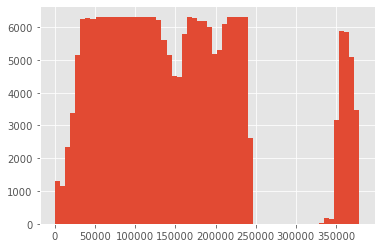

skew :  0.7916699204304766

Анализируем: quantity


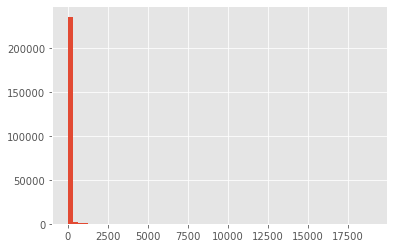

skew :  34.1369612904546

Анализируем: percent_manual_disc


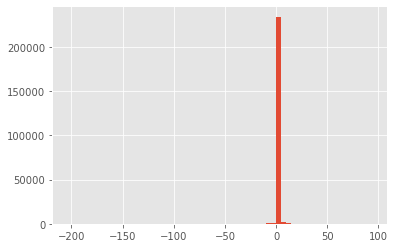

skew :  -15.41571391424351

Анализируем: percent_auto_disc


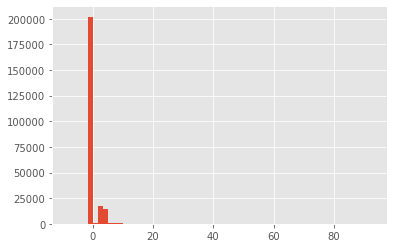

skew :  4.089986485204256

Анализируем: rast


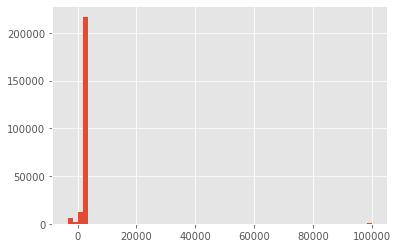

skew :  16.23800603921817

Переменные для которых необходимо провести преобразование:
['row_index', 'quantity', 'percent_manual_disc', 'percent_auto_disc', 'rast']

Переменные для которых НЕ нужно проводить преобразование:
[]


In [64]:
# Преобразования с numerical_columns для newDF
data_num = anylyse_numerical_columns(
    data, numerical_columns, 'cancell')

In [65]:
# Преобразование с categorical_columns для newDF
label_encoded_data = work_with_categorical_columns(
    data, categorical_columns, 'cancell')
# Теперь нужно склеить результат работы в новый DF:
# 1) numerical_columns:
#    1.1) data_num
# 2) categorical_columns:
#    2.1) label_encoded_data
encoded_data = pd.concat([data_num, label_encoded_data], axis=1)

In [66]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238833 entries, 0 to 244503
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   row_index            238833 non-null  float64
 1   quantity             238833 non-null  float64
 2   percent_manual_disc  238833 non-null  float64
 3   percent_auto_disc    238833 non-null  float64
 4   rast                 238833 non-null  float64
 5   nomenklatura_id      238833 non-null  int32  
 6   type_of_price_id     238833 non-null  int32  
 7   cancell              238833 non-null  int32  
 8   partner_id           238833 non-null  int32  
 9   date                 238833 non-null  int32  
dtypes: float64(5), int32(5)
memory usage: 25.5 MB


In [67]:
X2 = encoded_data.drop(columns='cancell')
y2 = encoded_data['cancell']

In [87]:
pridict(X2, y2)

Метод BernoulliNB()
при cv = KFold(n_splits=10, random_state=None, shuffle=False) scores.mean()= 0.5691211594449952
при cv = KFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= 0.5730323551561318
при cv = KFold(n_splits=10, random_state=42, shuffle=False) scores.mean()= 0.5691211594449952
при cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= 0.5730323218336344
при cv = ShuffleSplit(n_splits=10, random_state=42, test_size=0.3, train_size=0.7) scores.mean()= 0.5731686904221516


Метод ComplementNB()
при cv = KFold(n_splits=10, random_state=None, shuffle=False) scores.mean()= nan
при cv = KFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= nan
при cv = KFold(n_splits=10, random_state=42, shuffle=False) scores.mean()= nan
при cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) scores.mean()= nan
при cv = ShuffleSplit(n_splits=10, random_state=42, test_size=0.3, train_size=0.7) scores.mean()= nan


Метод GaussianNB()
при c

In [92]:
X2

,quantity,percent_manual_disc,percent_auto_disc,rast,nomenklatura_id,type_of_price_id,partner_id,date
0,2.558632,0.000000,-0.0,1951.299070,1680,0,3826,53
1,4.032439,0.000000,-0.0,1951.299070,957,0,3826,53
2,0.000000,0.000000,-0.0,1947.563550,1628,0,3677,53
3,0.000000,0.000000,-0.0,1949.698206,239,0,4478,53
4,0.667789,0.000000,-0.0,1949.698206,625,0,4478,53
...,...,...,...,...,...,...,...,...
239757,2.845492,0.000000,-0.0,1950.765461,1440,0,4083,53
239758,2.038127,3.435246,-0.0,1955.033992,587,0,4323,53
239759,2.038127,3.435246,-0.0,1955.033992,759,0,4323,53
239760,1.955534,0.000000,-0.0,1951.299070,540,0,3826,53


# Системы моделей

## Построение Bagging моделей

In [68]:
X_train, X_control, y_train, y_control = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [69]:
# Bagging модели
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
# Оценщики Bagging моделей
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [70]:
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [71]:
param_grid = {
    'base_estimator': [ExtraTreesClassifier(),
                       LinearSVC(), SVC()],
    'n_estimators': [3, 10, 15, 20],
    'max_samples': [1, 5, 10, 15, 20],
    'max_features': [1, 5, 10],
    'bootstrap': [True, False]
}

In [72]:
Bag_class_model = BaggingClassifier()
Grid_bagging_model = GridSearchCV(Bag_class_model, param_grid, n_jobs=-1)
Grid_bagging_model.fit(X_train, y_train)
print(Grid_bagging_model.best_params_)
print(f'Оценка правильности: {Grid_bagging_model.score(X_control, y_control)}')

{'base_estimator': ExtraTreesClassifier(), 'bootstrap': True, 'max_features': 5, 'max_samples': 20, 'n_estimators': 20}


NameError: name 'X_test' is not defined

In [73]:
print(f'Оценка правильности: {Grid_bagging_model.score(X_control, y_control)}')

Оценка правильности: 0.5614375436147941


## Построение Boosting моделей

In [74]:
param_grid = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.2, 0.6],
    'n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'subsample': [0.5, 1, 1.5],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [77]:
# Boost модели
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from xgboost import XGBClassifier
# Оценщики Boost моделей
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

In [ ]:
Gr_boosting_class_model = GradientBoostingClassifier()

Grid_boost_model = GridSearchCV(Gr_boosting_class_model, param_grid, n_jobs=-1)
Grid_boost_model.fit(X_train, y_train)
print(Grid_boost_model.best_params_)
print(f'Оценка правильности: {Grid_boost_model.score(X_control, y_control)}')

## Построение Stacking моделей

In [ ]:
# Stacking модели
from sklearn.ensemble import StackingClassifier, StackingRegressor
# Оценщик Stacking моделей
from sklearn.linear_model import LogisticRegression, RidgeCV, LinearRegression, SGDRegressor

In [ ]:
estimators = [('lg', LogisticRegression()),
              ('knn_cl', KNeighborsClassifier())]

St_class_model = StackingClassifier(estimators=estimators,
                                    final_estimator=RandomForestClassifier())

St_class_model.fit(X_train, y_train)

In [ ]:
f'Средняя точность с тестовыми данными с двумя моделями: {St_class_model.score(X_control, y_control)}'

In [ ]:
#Три модели

In [ ]:
estimators = [('knn_cl', KNeighborsClassifier()),
              ('etc_cl', ExtraTreesClassifier(n_estimators=10,
                                              random_state=42))]

St_class_model = StackingClassifier(estimators=estimators,
                                    final_estimator=RandomForestClassifier())

St_class_model.fit(X_train, y_train)

In [ ]:
f'Средняя точность с тестовыми данными с тремя моделями: {St_class_model.score(X_control, y_control)}'

In [ ]:
# Четыре модели

In [ ]:
estimators = [('knn_cl', KNeighborsClassifier()),
              ('etc_cl', ExtraTreesClassifier(n_estimators=10, random_state=42)),
              ('rf_cl', RandomForestClassifier())]

St_class_model = StackingClassifier(estimators=estimators,
                                    final_estimator=RandomForestClassifier())

St_class_model.fit(X_train, y_train)

In [ ]:
f'Средняя точность с тестовыми данными с четырьмя моделями: {St_class_model.score(X_control, y_control)}'